使用sklearn进行数据集转换。

# 管道与复合估计器

## 管道

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

estimators = [
  ("reduce_dim", PCA()),
  ("clf", SVC())
]

pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])

In [2]:
from sklearn.pipeline import make_pipeline

make_pipeline(PCA(), SVC())

Pipeline(steps=[('pca', PCA()), ('svc', SVC())])

In [3]:
pipe[:1]

pipe[-1:]

Pipeline(steps=[('clf', SVC())])

In [7]:
pipe.steps[0]

pipe[1]

SVC()

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest

iris = load_iris()
pipe = Pipeline(steps=[
    ("select", SelectKBest(k=2)),
    ("clf", LogisticRegression())
])

pipe.fit(iris.data, iris.target)

pipe[:-1].get_feature_names_out()

# array(['x2', 'x3'], dtype=object)

array(['x2', 'x3'], dtype=object)

In [10]:
pipe[0].get_feature_names_out()

array(['x2', 'x3'], dtype=object)

In [12]:
pipe = Pipeline(steps=[("reduce_dim", PCA()), ("clf", SVC())])
pipe.set_params(clf__C=10)

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC(C=10))])

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(
    reduce_dim__n_components=[2, 5, 10],
    clf__C=[0.1, 10, 100]
)

grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [14]:
param_grid = dict(
    reduce_dim=['passthrough', PCA(5), PCA(10)],
    clf=[SVC(), LogisticRegression()],
    clf__C=[0.1, 10, 100]
)

grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [15]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)
pipe
# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

In [ ]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
pca1 = PCA(n_components=10)
svm1 = SVC()
pipe = Pipeline([('reduce_dim', pca1), ('clf', svm1)])
pipe.fit(X_digits, y_digits)
# The pca instance can be inspected directly
pca1.components_.shape

# (10, 64)

(10, 64)

In [17]:
cachedir = mkdtemp()
pca2 = PCA(n_components=10)
svm2 = SVC()
cached_pipe = Pipeline([('reduce_dim', pca2), ('clf', svm2)],
                       memory=cachedir)
cached_pipe.fit(X_digits, y_digits)
cached_pipe.named_steps['reduce_dim'].components_.shape
# Remove the cache directory
rmtree(cachedir)

## 目标特征转换

In [18]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X, y = fetch_california_housing(return_X_y=True)
X, y = X[:2000, :], y[:2000]  # select a subset of data
transformer = QuantileTransformer(output_distribution='normal')
regressor = LinearRegression()
regr = TransformedTargetRegressor(
    regressor=regressor,
    transformer=transformer
)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))
raw_target_regr = LinearRegression().fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.61
R2 score: 0.59


In [19]:
def func(x):
    return np.log(x)
def inverse_func(x):
    return np.exp(x)

In [20]:
regr = TransformedTargetRegressor(
    regressor=regressor,
    func=func,
    inverse_func=inverse_func
)

regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: 0.51


In [ ]:
def inverse_func(x):
    return x
regr = TransformedTargetRegressor(
    regressor=regressor,
    func=func,
    inverse_func=inverse_func,
    check_inverse=False
)
regr.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: -1.57


## FeatureUnion

In [22]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
estimators = [
    ("linear_pca", PCA()),
    ("kernel_pca", KernelPCA())
]
combined = FeatureUnion(estimators)
combined

FeatureUnion(transformer_list=[('linear_pca', PCA()),
                               ('kernel_pca', KernelPCA())])

In [23]:
from sklearn.pipeline import make_union

make_union(PCA(), KernelPCA())

FeatureUnion(transformer_list=[('pca', PCA()), ('kernelpca', KernelPCA())])

In [26]:
combined.set_params(kernel_pca="drop")

FeatureUnion(transformer_list=[('linear_pca', PCA()), ('kernel_pca', 'drop')])

## 异构数据的列转换器

In [27]:
import pandas as pd
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'title': ["His Last Bow", "How Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})

In [28]:
X

,city,title,expert_rating,user_rating
0,London,His Last Bow,5,4
1,London,How Watson Learned the Trick,3,5
2,Paris,A Moveable Feast,4,4
3,Sallisaw,The Grapes of Wrath,5,3


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
    [('categories', OneHotEncoder(dtype='int'), ['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop',
    verbose_feature_names_out=False
)

column_trans.fit(X)

column_trans.get_feature_names_out()

column_trans.transform(X).toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
ct = ColumnTransformer([
      ('scale', StandardScaler(),
      make_column_selector(dtype_include=np.number)),
      ('onehot',
      OneHotEncoder(),
      make_column_selector(pattern='city', dtype_include=object))])
ct.fit_transform(X)

array([[ 0.90453403,  0.        ,  1.        ,  0.        ,  0.        ],
       [-1.50755672,  1.41421356,  1.        ,  0.        ,  0.        ],
       [-0.30151134,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.90453403, -1.41421356,  0.        ,  0.        ,  1.        ]])

In [31]:
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='passthrough')

column_trans.fit_transform(X)

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 4],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 5],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 5, 3]])

In [32]:
from sklearn.preprocessing import MinMaxScaler
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(), ['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder=MinMaxScaler())

column_trans.fit_transform(X)[:, -2:]

array([[1. , 0.5],
       [0. , 1. ],
       [0.5, 0.5],
       [1. , 0. ]])

In [33]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['city']),
    (CountVectorizer(), 'title'),
    remainder=MinMaxScaler())
column_trans

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])

In [34]:
ct = ColumnTransformer(
         [("scale", StandardScaler(), ["expert_rating"])]).fit(X)
X_new = pd.DataFrame({"expert_rating": [5, 6, 1],
                      "ignored_new_col": [1.2, 0.3, -0.1]})
ct.transform(X_new)

array([[ 0.90453403],
       [ 2.11057941],
       [-3.91964748]])

# 特征提取

## 从字典加载特征

In [35]:
measurements = [
    {'city': 'Dubai', 'temperature': 33.},
    {'city': 'London', 'temperature': 12.},
    {'city': 'San Francisco', 'temperature': 18.},
]

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()

vec.fit_transform(measurements).toarray()

vec.get_feature_names_out()

array(['city=Dubai', 'city=London', 'city=San Francisco', 'temperature'],
      dtype=object)

In [ ]:
movie_entry = [{'category': ['thriller', 'drama'], 'year': 2003},
               {'category': ['animation', 'family'], 'year': 2011},
               {'year': 1974}]
vec.fit_transform(movie_entry).toarray()
vec.get_feature_names_out()
vec.transform({'category': ['thriller'],
               'unseen_feature': '3'}).toarray()

# array([[0., 0., 0., 1., 0.]])

array([[0., 0., 0., 1., 0.]])

In [37]:
pos_window = [
    {
        'word-2': 'the',
        'pos-2': 'DT',
        'word-1': 'cat',
        'pos-1': 'NN',
        'word+1': 'on',
        'pos+1': 'PP',
    },
    # in a real application one would extract many such dictionaries
]

In [ ]:
vec = DictVectorizer()
pos_vectorized = vec.fit_transform(pos_window)
pos_vectorized
pos_vectorized.toarray()
vec.get_feature_names_out()

# array(['pos+1=PP', 'pos-1=NN', 'pos-2=DT', 'word+1=on', 'word-1=cat',
#        'word-2=the'], dtype=object)

array(['pos+1=PP', 'pos-1=NN', 'pos-2=DT', 'word+1=on', 'word-1=cat',
       'word-2=the'], dtype=object)

## 特征哈希

In [39]:
def token_features(token, part_of_speech):
    if token.isdigit():
        yield "numeric"
    else:
        yield "token={}".format(token.lower())
        yield "token,pos={},{}".format(token, part_of_speech)
    if token[0].isupper():
        yield "uppercase_initial"
    if token.isupper():
        yield "all_uppercase"
    yield "pos={}".format(part_of_speech)

## 文本特征提取

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
vectorizer = CountVectorizer()
vectorizer

CountVectorizer()

In [43]:
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)
X

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [44]:
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [ ]:
vectorizer.get_feature_names_out()

X.toarray()

# array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
#        [0, 1, 0, 1, 0, 2, 1, 0, 1],
#        [1, 0, 0, 0, 1, 0, 1, 1, 0],
#        [0, 1, 1, 1, 0, 0, 1, 0, 1]])

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [ ]:
vectorizer.vocabulary_.get('document')

# 1

1

In [ ]:
vectorizer.transform(['Something completely new.']).toarray()

# array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [48]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!') == (
    ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

True

# 数据预处理

## 标准化

In [52]:
from sklearn import preprocessing
import numpy as np
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
scaler = preprocessing.StandardScaler().fit(X_train)
scaler

scaler.mean_

scaler.scale_

X_scaled = scaler.transform(X_train)
X_scaled

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [53]:
preprocessing.StandardScaler().fit_transform(X_train)

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [54]:
X_scaled.mean(axis=0)

X_scaled.std(axis=0)

array([1., 1., 1.])

In [55]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.96

In [56]:
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_train_minmax

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

In [57]:
X_test = np.array([[-3., -1.,  4.]])
X_test_minmax = min_max_scaler.transform(X_test)
X_test_minmax

array([[-1.5       ,  0.        ,  1.66666667]])

In [58]:
min_max_scaler.scale_

min_max_scaler.min_

array([0.        , 0.5       , 0.33333333])

In [59]:
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_maxabs = max_abs_scaler.fit_transform(X_train)
X_train_maxabs
X_test = np.array([[ -3., -1.,  4.]])
X_test_maxabs = max_abs_scaler.transform(X_test)
X_test_maxabs
max_abs_scaler.scale_

array([2., 1., 2.])

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)
np.percentile(X_train[:, 0], [0, 25, 50, 75, 100]) 

# array([4.3, 5.1, 5.8, 6.5, 7.9])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(


array([4.3, 5.1, 5.8, 6.5, 7.9])

In [ ]:
np.percentile(X_train_trans[:, 0], [0, 25, 50, 75, 100])

# array([0.        , 0.23873874, 0.50900901, 0.74324324, 1.        ])

array([0.        , 0.23873874, 0.50900901, 0.74324324, 1.        ])

In [ ]:
np.percentile(X_test[:, 0], [0, 25, 50, 75, 100])

np.percentile(X_test_trans[:, 0], [0, 25, 50, 75, 100])

# array([0.01351351, 0.25      , 0.47747748, 0.60472973, 0.94144144])

array([0.01351351, 0.25      , 0.47747748, 0.60472973, 0.94144144])

In [ ]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
X_lognormal = np.random.RandomState(616).lognormal(size=(3, 3))
X_lognormal
pt.fit_transform(X_lognormal)

# array([[ 0.49024348,  0.17881995, -0.1563781 ],
#        [-0.05102892,  0.58863195, -0.57612415],
#        [ 0.69420008, -0.84857823,  0.10051454]])

array([[ 0.49024348,  0.17881995, -0.1563781 ],
       [-0.05102892,  0.58863195, -0.57612415],
       [ 0.69420008, -0.84857823,  0.10051454]])

In [64]:
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=0)
X_trans = quantile_transformer.fit_transform(X)
quantile_transformer.quantiles_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  warnings.warn(


array([[4.3, 2. , 1. , 0.1],
       [4.4, 2.2, 1.1, 0.1],
       [4.4, 2.2, 1.2, 0.1],
       [4.4, 2.2, 1.2, 0.1],
       [4.5, 2.3, 1.3, 0.1],
       [4.6, 2.3, 1.3, 0.2],
       [4.6, 2.3, 1.3, 0.2],
       [4.6, 2.3, 1.3, 0.2],
       [4.6, 2.4, 1.3, 0.2],
       [4.7, 2.4, 1.3, 0.2],
       [4.7, 2.4, 1.3, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.9, 2.5, 1.4, 0.2],
       [4.9, 2.5, 1.4, 0.2],
       [4.9, 2.5, 1.4, 0.2],
       [4.9, 2.6, 1.4, 0.2],
       [4.9, 2.6, 1.4, 0.2],
       [4.9, 2.6, 1.4, 0.2],
       [5. , 2.6, 1.4, 0.2],
       [5. , 2.6, 1.4, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5.1, 2.7, 1.5, 0.2],
       [5.1, 2.8, 1.5, 0.2],
       [5.1, 2

## 归一化

In [65]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]
X_normalized = preprocessing.normalize(X, norm='l2')

X_normalized

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [66]:
normalizer = preprocessing.Normalizer().fit(X)  # fit does nothing
normalizer

Normalizer()

In [67]:
normalizer.transform(X)

normalizer.transform([[-1.,  1., 0.]])

array([[-0.70710678,  0.70710678,  0.        ]])

## 分类特征编码

In [68]:
enc = preprocessing.OrdinalEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from US', 'uses Safari']])

array([[0., 1., 1.]])

In [ ]:
enc = preprocessing.OrdinalEncoder()
X = [['male'], ['female'], [np.nan], ['female']]
enc.fit_transform(X)

# array([[ 1.],
#        [ 0.],
#        [nan],
#        [ 0.]])

array([[ 1.],
       [ 0.],
       [nan],
       [ 0.]])

In [ ]:
enc = preprocessing.OrdinalEncoder(encoded_missing_value=-1)
X = [['male'], ['female'], [np.nan], ['female']]
enc.fit_transform(X)

# array([[ 1.],
#        [ 0.],
#        [-1.],
#        [ 0.]])

array([[ 1.],
       [ 0.],
       [-1.],
       [ 0.]])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
enc = Pipeline(steps=[
    ("encoder", preprocessing.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
])
enc.fit_transform(X)

# array([[ 1.],
#        [ 0.],
#        [-1.],
#        [ 0.]])

array([[ 1.],
       [ 0.],
       [-1.],
       [ 0.]])

In [ ]:
enc = preprocessing.OneHotEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from US', 'uses Safari'],
               ['male', 'from Europe', 'uses Safari']]).toarray()

# array([[1., 0., 0., 1., 0., 1.],
#        [0., 1., 1., 0., 0., 1.]])

array([[1., 0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 1.]])

In [ ]:
enc.categories_

# [array(['female', 'male'], dtype=object),
#  array(['from Europe', 'from US'], dtype=object),
#  array(['uses Firefox', 'uses Safari'], dtype=object)]

[array(['female', 'male'], dtype=object),
 array(['from Europe', 'from US'], dtype=object),
 array(['uses Firefox', 'uses Safari'], dtype=object)]

In [ ]:
genders = ['female', 'male']
locations = ['from Africa', 'from Asia', 'from Europe', 'from US']
browsers = ['uses Chrome', 'uses Firefox', 'uses IE', 'uses Safari']
enc = preprocessing.OneHotEncoder(categories=[genders, locations, browsers])
# Note that for there are missing categorical values for the 2nd and 3rd
# feature
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from Asia', 'uses Chrome']]).toarray()

# array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])

array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])

In [ ]:
enc = preprocessing.OneHotEncoder(handle_unknown='infrequent_if_exist')
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from Asia', 'uses Chrome']]).toarray()

# array([[1., 0., 0., 0., 0., 0.]])

array([[1., 0., 0., 0., 0., 0.]])

In [ ]:
X = [['male', 'from US', 'uses Safari'],
     ['female', 'from Europe', 'uses Firefox']]
drop_enc = preprocessing.OneHotEncoder(drop='first').fit(X)
drop_enc.categories_
drop_enc.transform(X).toarray()

# array([[1., 1., 1.],
#        [0., 0., 0.]])

array([[1., 1., 1.],
       [0., 0., 0.]])

In [ ]:
X = [['male', 'US', 'Safari'],
     ['female', 'Europe', 'Firefox'],
     ['female', 'Asia', 'Chrome']]
drop_enc = preprocessing.OneHotEncoder(drop='if_binary').fit(X)
drop_enc.categories_
drop_enc.transform(X).toarray()

# array([[1., 0., 0., 1., 0., 0., 1.],
#        [0., 0., 1., 0., 0., 1., 0.],
#        [0., 1., 0., 0., 1., 0., 0.]])

array([[1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0.]])

In [ ]:
drop_enc = preprocessing.OneHotEncoder(drop='first',
                                       handle_unknown='ignore').fit(X)
X_test = [['unknown', 'America', 'IE']]
drop_enc.transform(X_test).toarray()

# array([[0., 0., 0., 0., 0.]])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[0., 0., 0., 0., 0.]])

In [ ]:
drop_enc = preprocessing.OneHotEncoder(drop='if_binary', sparse_output=False,
                                       handle_unknown='ignore').fit(X)
X_test = [['unknown', 'America', 'IE']]
X_trans = drop_enc.transform(X_test)
X_trans
drop_enc.inverse_transform(X_trans)

# array([['female', None, None]], dtype=object)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([['female', None, None]], dtype=object)

In [ ]:
X = np.array([['dog'] * 5 + ['cat'] * 20 + ['rabbit'] * 10 +
              ['snake'] * 3], dtype=object).T
enc = preprocessing.OrdinalEncoder(min_frequency=6).fit(X)
enc.infrequent_categories_
enc.transform(np.array([['dog'], ['cat'], ['rabbit'], ['snake']]))

# array([[2.],
#        [0.],
#        [1.],
#        [2.]])

array([[2.],
       [0.],
       [1.],
       [2.]])

In [ ]:
X_train = np.array(
    [["a"] * 5 + ["b"] * 20 + ["c"] * 10 + ["d"] * 3 + [np.nan]],
    dtype=object).T
enc = preprocessing.OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=3,
    max_categories=3, encoded_missing_value=4)
_ = enc.fit(X_train)
X_test = np.array([["a"], ["b"], ["c"], ["d"], ["e"], [np.nan]], dtype=object)
enc.transform(X_test)

# array([[2.],
#        [0.],
#        [1.],
#        [2.],
#        [3.],
#        [4.]])

array([[2.],
       [0.],
       [1.],
       [2.],
       [3.],
       [4.]])

In [ ]:
X_train = np.array(
    [["a"] * 5 + ["b"] * 20 + ["c"] * 10 + ["d"] * 3 + [np.nan]],
    dtype=object).T
enc = preprocessing.OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=3,
    max_categories=3, encoded_missing_value=4)
_ = enc.fit(X_train)
X_test = np.array([["a"], ["b"], ["c"], ["d"], ["e"], [np.nan]], dtype=object)
enc.transform(X_test)

# array([[2.],
#        [0.],
#        [1.],
#        [2.],
#        [3.],
#        [4.]])

array([[2.],
       [0.],
       [1.],
       [2.],
       [3.],
       [4.]])

In [ ]:
enc = preprocessing.OneHotEncoder(min_frequency=6, sparse_output=False).fit(X)
enc.infrequent_categories_
enc.transform(np.array([['dog'], ['cat'], ['rabbit'], ['snake']]))

# array([[0., 0., 1.],
#        [1., 0., 0.],
#        [0., 1., 0.],
#        [0., 0., 1.]])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
enc = preprocessing.OneHotEncoder(
   handle_unknown='infrequent_if_exist', sparse_output=False, min_frequency=6)
enc = enc.fit(X)
enc.transform(np.array([['dragon']]))

# array([[0., 0., 1.]])

array([[0., 0., 1.]])

In [ ]:
enc.get_feature_names_out()

# array(['x0_cat', 'x0_rabbit', 'x0_infrequent_sklearn'], dtype=object)

array(['x0_cat', 'x0_rabbit', 'x0_infrequent_sklearn'], dtype=object)

In [ ]:
enc = preprocessing.OneHotEncoder(max_categories=2, sparse_output=False)
enc = enc.fit(X)
enc.transform([['dog'], ['cat'], ['rabbit'], ['snake']])

# array([[0., 1.],
#        [1., 0.],
#        [0., 1.],
#        [0., 1.]])

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [ ]:
enc = preprocessing.OneHotEncoder(min_frequency=4, max_categories=3, sparse_output=False)
enc = enc.fit(X)
enc.transform([['dog'], ['cat'], ['rabbit'], ['snake']])

# array([[0., 0., 1.],
#        [1., 0., 0.],
#        [0., 1., 0.],
#        [0., 0., 1.]])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## 离散化

In [90]:
X = np.array([[ -3., 5., 15 ],
              [  0., 6., 14 ],
              [  6., 3., 11 ]])
est = preprocessing.KBinsDiscretizer(n_bins=[3, 2, 2], encode='ordinal').fit(X)

In [ ]:
est.transform(X)

# array([[0., 1., 1.],
#        [1., 1., 1.],
#        [2., 0., 0.]])

array([[0., 1., 1.],
       [1., 1., 1.],
       [2., 0., 0.]])

In [ ]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

binarizer = preprocessing.Binarizer().fit(X)  # fit does nothing
binarizer

binarizer.transform(X)

# array([[1., 0., 1.],
#        [1., 0., 0.],
#        [0., 1., 0.]])

array([[1., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
binarizer = preprocessing.Binarizer(threshold=1.1)
binarizer.transform(X)

# array([[0., 0., 1.],
#        [1., 0., 0.],
#        [0., 0., 0.]])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 0.]])

## 生成多项式特征

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
X = np.arange(6).reshape(3, 2)
X
poly = PolynomialFeatures(2)
poly.fit_transform(X)

# array([[ 1.,  0.,  1.,  0.,  0.,  1.],
#        [ 1.,  2.,  3.,  4.,  6.,  9.],
#        [ 1.,  4.,  5., 16., 20., 25.]])

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [ ]:
X = np.arange(9).reshape(3, 3)
X
poly = PolynomialFeatures(degree=3, interaction_only=True)
poly.fit_transform(X)

# array([[  1.,   0.,   1.,   2.,   0.,   0.,   2.,   0.],
#        [  1.,   3.,   4.,   5.,  12.,  15.,  20.,  60.],
#        [  1.,   6.,   7.,   8.,  42.,  48.,  56., 336.]])

array([[  1.,   0.,   1.,   2.,   0.,   0.,   2.,   0.],
       [  1.,   3.,   4.,   5.,  12.,  15.,  20.,  60.],
       [  1.,   6.,   7.,   8.,  42.,  48.,  56., 336.]])

In [ ]:
import numpy as np
from sklearn.preprocessing import SplineTransformer
X = np.arange(5).reshape(5, 1)
X
spline = SplineTransformer(degree=2, n_knots=3)
spline.fit_transform(X)

# array([[0.5  , 0.5  , 0.   , 0.   ],
#        [0.125, 0.75 , 0.125, 0.   ],
#        [0.   , 0.5  , 0.5  , 0.   ],
#        [0.   , 0.125, 0.75 , 0.125],
#        [0.   , 0.   , 0.5  , 0.5  ]])

array([[0.5  , 0.5  , 0.   , 0.   ],
       [0.125, 0.75 , 0.125, 0.   ],
       [0.   , 0.5  , 0.5  , 0.   ],
       [0.   , 0.125, 0.75 , 0.125],
       [0.   , 0.   , 0.5  , 0.5  ]])

## 自定义转换器

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
X = np.array([[0, 1], [2, 3]])
# Since FunctionTransformer is no-op during fit, we can call transform directly
transformer.transform(X)

# array([[0.        , 0.69314718],
#        [1.09861229, 1.38629436]])

array([[0.        , 0.69314718],
       [1.09861229, 1.38629436]])

In [98]:
from sklearn.utils import Bunch
import numpy as np

# 假设你已经有了自己的数据
my_features = np.array([[1, 20], [2, 21], [3, 22]])
my_labels = np.array([0, 1, 0])
my_feature_names = ['age', 'height']
my_description = "A small custom dataset about people."

# 手动创建 Bunch 对象
custom_dataset = Bunch(
    data=my_features,
    target=my_labels,
    feature_names=my_feature_names,
    DESCR=my_description,
    filename='my_custom_data.csv', # 可选，或其他元数据
    target_names=['class_A', 'class_B'] # 可选
)

# 访问数据
print(custom_dataset.data)
# [[ 1 20]
#  [ 2 21]
#  [ 3 22]]

print(custom_dataset['feature_names'])
# ['age', 'height']

print(custom_dataset.DESCR)
# A small custom dataset about people.

[[ 1 20]
 [ 2 21]
 [ 3 22]]
['age', 'height']
A small custom dataset about people.


# 缺失值插补

## 单变量特征插补

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))

# [[4.         2.        ]
#  [6.         3.66666667]
#  [7.         6.        ]]

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


In [ ]:
import scipy.sparse as sp
X = sp.csc_matrix([[1, 2], [0, -1], [8, 4]])
imp = SimpleImputer(missing_values=-1, strategy='mean')
imp.fit(X)
X_test = sp.csc_matrix([[-1, 2], [6, -1], [7, 6]])
print(imp.transform(X_test).toarray())

# [[3. 2.]
#  [6. 3.]
#  [7. 6.]]

[[3. 2.]
 [6. 3.]
 [7. 6.]]


In [ ]:
import pandas as pd
df = pd.DataFrame([["a", "x"],
                   [np.nan, "y"],
                   ["a", np.nan],
                   ["b", "y"]], dtype="category")
imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))

# [['a' 'x']
#  ['a' 'y']
#  ['a' 'y']
#  ['b' 'y']]

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


## 多变量插补

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
# the model learns that the second feature is double the first
print(np.round(imp.transform(X_test)))

# [[ 1.  2.]
#  [ 6. 12.]
#  [ 3.  6.]]

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


In [ ]:
import numpy as np
from sklearn.impute import KNNImputer
nan = np.nan
X = [[1, 2, nan], [3, 4, 3], [nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(X)

# array([[1. , 2. , 4. ],
#        [3. , 4. , 3. ],
#        [5.5, 6. , 5. ],
#        [8. , 8. , 7. ]])

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

## 保持特征数量不变

In [ ]:
imputer = SimpleImputer()
X = np.array([[np.nan, 1], [np.nan, 2], [np.nan, 3]])
imputer.fit_transform(X)

# array([[1.],
#        [2.],
#        [3.]])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


array([[1.],
       [2.],
       [3.]])

In [ ]:
imputer.set_params(keep_empty_features=True)
imputer.fit_transform(X)

# array([[0., 1.],
#        [0., 2.],
#        [0., 3.]])

array([[0., 1.],
       [0., 2.],
       [0., 3.]])

## 指示符

In [ ]:
from sklearn.impute import MissingIndicator
X = np.array([[-1, -1, 1, 3],
              [4, -1, 0, -1],
              [8, -1, 1, 0]])
indicator = MissingIndicator(missing_values=-1)
mask_missing_values_only = indicator.fit_transform(X)
mask_missing_values_only

# array([[ True,  True, False],
#        [False,  True,  True],
#        [False,  True, False]])

array([[ True,  True, False],
       [False,  True,  True],
       [False,  True, False]])

In [9]:
indicator.features_

array([0, 1, 3])

In [10]:
indicator = MissingIndicator(missing_values=-1, features="all")
mask_all = indicator.fit_transform(X)
mask_all
indicator.features_

array([0, 1, 2, 3])

In [11]:
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
X, y = load_iris(return_X_y=True)
mask = np.random.randint(0, 2, size=X.shape).astype(bool)
X[mask] = np.nan
X_train, X_test, y_train, _ = train_test_split(X, y, test_size=100,
                                               random_state=0)

In [12]:
transformer = FeatureUnion(
    transformer_list=[
        ('features', SimpleImputer(strategy='mean')),
        ('indicators', MissingIndicator())])
transformer = transformer.fit(X_train, y_train)
results = transformer.transform(X_test)
results.shape

(100, 8)

In [13]:
clf = make_pipeline(transformer, DecisionTreeClassifier())
clf = clf.fit(X_train, y_train)
results = clf.predict(X_test)
results.shape

(100,)

# 特征降维

## PCA

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits

# 加载手写数字数据集
digits = load_digits()

# 创建一个管道 (Pipeline)
# 步骤1: PCA降维，将64维降到15维
# 步骤2: 逻辑回归分类器
pipe = Pipeline([
    ('pca', PCA(n_components=15, random_state=42)),
    ('logistic', LogisticRegression(max_iter=5000, random_state=42))
])

# 拟合管道
pipe.fit(digits.data, digits.target)

# 预测
predictions = pipe.predict(digits.data)

# 评分
score = pipe.score(digits.data, digits.target)
score

0.9727323316638843

## 随机投影

In [17]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from scipy.spatial.distance import euclidean

# --- 1. 创建一个高维合成数据集 ---
# 假设我们有 200 个样本，每个样本有 10000 个特征
n_samples = 200
n_features = 10000

print(f"开始创建数据...")
X = np.random.rand(n_samples, n_features)
print(f"原始数据形状: {X.shape} (样本数, 特征数)")
print("-" * 50)


# --- 2. 使用高斯随机投影 (GaussianRandomProjection) ---
# 我们的目标是将 10000 维降到 300 维
n_components = 300

print(f"应用高斯随机投影...")
# 初始化高斯随机投影转换器
# random_state 用于确保每次运行结果一致
transformer_gaussian = GaussianRandomProjection(
    n_components=n_components,
    random_state=42
)

# 对数据进行拟合和转换
X_new_gaussian = transformer_gaussian.fit_transform(X)

print(f"高斯随机投影后数据形状: {X_new_gaussian.shape}")
print("-" * 50)


# --- 3. 使用稀疏随机投影 (SparseRandomProjection) ---
# 稀疏随机投影在计算速度和内存使用上通常更有优势
print(f"应用稀疏随机投影...")
# 初始化稀疏随机投影转换器
transformer_sparse = SparseRandomProjection(
    n_components=n_components,
    random_state=42
)

# 对数据进行拟合和转换
X_new_sparse = transformer_sparse.fit_transform(X)

print(f"稀疏随机投影后数据形状: {X_new_sparse.shape}")
print("-" * 50)


# --- 4. 验证距离保留特性 ---
# 随机选择两个样本点
sample_1_orig = X[0]
sample_2_orig = X[100]

# 在降维前计算它们的欧氏距离
dist_original = euclidean(sample_1_orig, sample_2_orig)
print(f"原始空间中两个样本的距离: {dist_original:.4f}")

# 在高斯随机投影降维后的空间中计算它们的距离
sample_1_gaussian = X_new_gaussian[0]
sample_2_gaussian = X_new_gaussian[100]
dist_gaussian = euclidean(sample_1_gaussian, sample_2_gaussian)
print(f"高斯投影后空间中的距离:   {dist_gaussian:.4f}")

# 在稀疏随机投影降维后的空间中计算它们的距离
sample_1_sparse = X_new_sparse[0]
sample_2_sparse = X_new_sparse[100]
dist_sparse = euclidean(sample_1_sparse, sample_2_sparse)
print(f"稀疏投影后空间中的距离:   {dist_sparse:.4f}")

# 我们可以看到，虽然降维后的绝对距离发生了变化，但它们仍然在同一个数量级上。
# JL引理保证的是距离的扭曲程度在一个可控范围内。
# 降维后的距离 ≈ c * 原始距离，其中 c 是一个缩放因子。
# 我们可以比较一下距离的比率
print(f"\n高斯投影后的距离 / 原始距离 = {dist_gaussian / dist_original:.4f}")
print(f"稀疏投影后的距离 / 原始距离 = {dist_sparse / dist_original:.4f}")

开始创建数据...
原始数据形状: (200, 10000) (样本数, 特征数)
--------------------------------------------------
应用高斯随机投影...
高斯随机投影后数据形状: (200, 300)
--------------------------------------------------
应用稀疏随机投影...
稀疏随机投影后数据形状: (200, 300)
--------------------------------------------------
原始空间中两个样本的距离: 40.2641
高斯投影后空间中的距离:   41.5412
稀疏投影后空间中的距离:   39.6401

高斯投影后的距离 / 原始距离 = 1.0317
稀疏投影后的距离 / 原始距离 = 0.9845


## 特征聚合

原始数据形状: (200, 10)


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaV

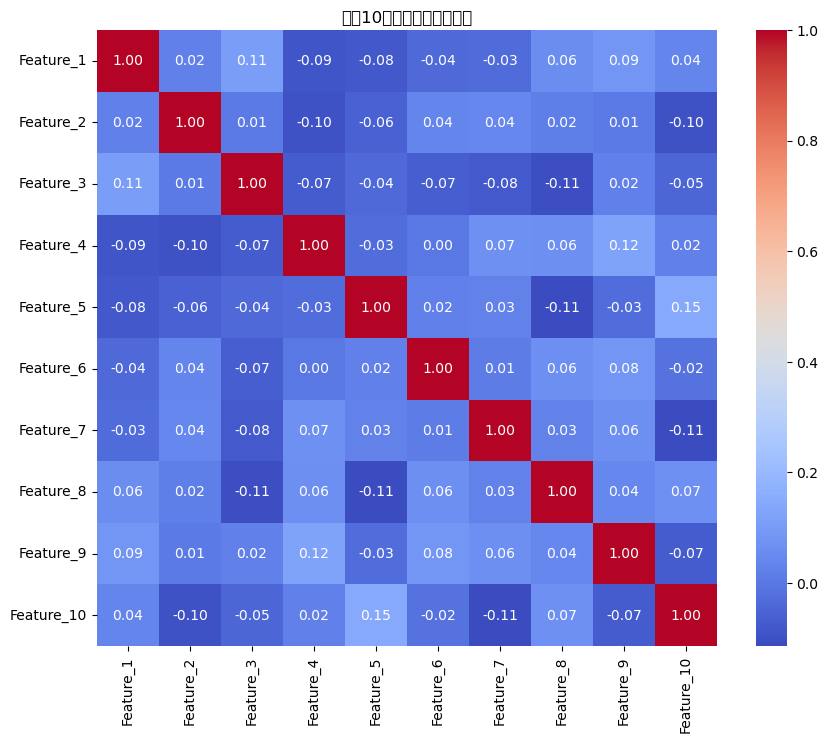


从上面的热力图中可以看到，许多特征之间存在明显的高度相关性（红色方块）。
------------------------------------------------------------
开始特征聚合，目标特征数量: 4
特征聚合后的新数据形状: (200, 4)


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaV

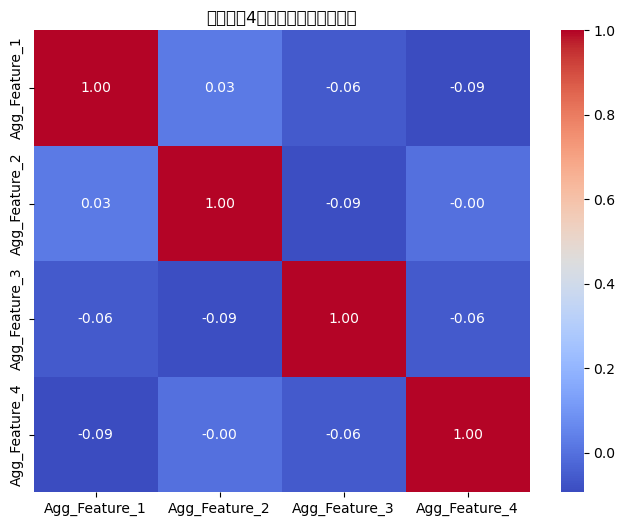


从上面的热力图中可以看到，新的聚合特征之间的相关性显著降低了。
这表明 FeatureAgglomeration 成功地将相关的原始特征合并，消除了冗余。

原始特征的分组情况 (0-3代表4个簇): [1 1 3 0 2 0 0 1 0 2]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.cluster import FeatureAgglomeration

# --- 1. 创建一个合成数据集 ---
# 我们创建10个特征，但其中只有3个是真正有信息量的。
# 其余的特征是这3个信息量特征的线性组合，因此它们之间会存在高度相关性。
X, y = make_regression(n_samples=200, n_features=10, n_informative=3, random_state=42)

print(f"原始数据形状: {X.shape}")

# 将数据转换为 Pandas DataFrame 以方便后续操作和可视化
X_df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])


# --- 2. 可视化原始特征的相关性 ---
# 计算特征之间的相关系数矩阵
corr_matrix_orig = X_df.corr()

# 使用热力图可视化相关性
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_orig, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('原始10个特征的相关性矩阵')
plt.show()

print("\n从上面的热力图中可以看到，许多特征之间存在明显的高度相关性（红色方块）。")
print("-" * 60)


# --- 3. 应用 FeatureAgglomeration 进行特征聚合 ---
# 我们的目标是将10个原始特征聚合为4个新的聚合特征
# n_clusters 就是降维后的目标特征数量
agglo = FeatureAgglomeration(n_clusters=4)

print(f"开始特征聚合，目标特征数量: {agglo.n_clusters}")

# 对数据进行拟合和转换
# .fit_transform() 会找出哪些特征应该被聚在一起，并返回合并后的新特征矩阵
X_reduced = agglo.fit_transform(X)

print(f"特征聚合后的新数据形状: {X_reduced.shape}")


# --- 4. 可视化聚合后新特征的相关性 ---
# 将聚合后的数据也转换为 DataFrame
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'Agg_Feature_{i+1}' for i in range(X_reduced.shape[1])])

# 计算新特征之间的相关系数矩阵
corr_matrix_reduced = X_reduced_df.corr()

# 使用热力图可视化新特征的相关性
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_reduced, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('聚合后的4个新特征的相关性矩阵')
plt.show()

print("\n从上面的热力图中可以看到，新的聚合特征之间的相关性显著降低了。")
print("这表明 FeatureAgglomeration 成功地将相关的原始特征合并，消除了冗余。")

# 你还可以查看每个原始特征被分配到了哪个簇（新的聚合特征）
# labels_ 属性的长度等于原始特征的数量
print(f"\n原始特征的分组情况 (0-3代表4个簇): {agglo.labels_}")

# 核近似

# 目标转换

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit([1, 2, 6, 4, 2])
lb.classes_
lb.transform([1, 6])

# array([[1, 0, 0, 0],
#        [0, 0, 0, 1]])

array([[1, 0, 0, 0],
       [0, 0, 0, 1]])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
y = [[2, 3, 4], [2], [0, 1, 3], [0, 1, 2, 3, 4], [0, 1, 2]]
MultiLabelBinarizer().fit_transform(y)

# array([[0, 0, 1, 1, 1],
#        [0, 0, 1, 0, 0],
#        [1, 1, 0, 1, 0],
#        [1, 1, 1, 1, 1],
#        [1, 1, 1, 0, 0]])

array([[0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0]])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([1, 2, 2, 6])
le.classes_
le.transform([1, 1, 2, 6])
le.inverse_transform([0, 0, 1, 2])

# array([1, 1, 2, 6])

array([1, 1, 2, 6])

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
list(le.classes_)
le.transform(["tokyo", "tokyo", "paris"])
list(le.inverse_transform([2, 2, 1]))

# ['tokyo', 'tokyo', 'paris']

['tokyo', 'tokyo', 'paris']